In [1]:
import sys
path ='/home/ashesh.ashesh/code/Disentangle'
if path in sys.path:
    sys.path.remove(path)
sys.path

['/home/ashesh.ashesh/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python313.zip',
 '/home/ashesh.ashesh/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13',
 '/home/ashesh.ashesh/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13/lib-dynload',
 '',
 '/localscratch/code/Disentangle/.venv/lib/python3.13/site-packages',
 '/localscratch/code/FinetuneSplit/src',
 '__editable__.semanticunmix-0.1.0.finder.__path_hook__']

In [2]:
from IPython.display import display, HTML
import os
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import torch
import numpy as np
import seaborn as sns

from disentangle.data_loader.patch_index_manager import TilingMode
from disentangle.core.sampler_type import SamplerType
from disentangle.core.loss_type import LossType
from disentangle.data_loader.ht_iba1_ki67_rawdata_loader import SubDsetType
from disentangle.analysis.stitch_prediction import stitch_predictions
from disentangle.analysis.mmse_prediction import get_dset_predictions
from disentangle.analysis.forward_operator_parameters import get_forward_operator_parameters
from disentangle.core.psnr import PSNR
from finetunesplit.posterior_sampler import get_transform_obj, PosteriorSampler, get_input_transform_obj
from disentangle.core.psnr import RangeInvariantPsnr

from finetunesplit.asymmetric_transforms import TransformEnum
from finetunesplit.calibration.calibration_coverage import compute_for_one_batch
from finetunesplit.calibration.grid_search import grid_search
from finetunesplit.calibration.grid_search import plot_coverage_plot
from finetunesplit.calibration.grid_search import get_percentage_occurance



/localscratch/code/Disentangle/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%run ./nb_core/root_dirs.ipynb
setup_syspath_disentangle(False)
%run ./nb_core/disentangle_imports.ipynb

DATA_ROOT:	 /group/jug/ashesh/data/
CODE_ROOT:	 /localscratch/


In [5]:
def get_dtype(ckpt_fpath):
    if os.path.isdir(ckpt_fpath):
        ckpt_fpath = ckpt_fpath[:-1] if ckpt_fpath[-1] == '/' else ckpt_fpath
    elif os.path.isfile(ckpt_fpath):
        ckpt_fpath = os.path.dirname(ckpt_fpath)
    assert ckpt_fpath[-1] != '/'
    return int(ckpt_fpath.split('/')[-2].split('-')[0][1:])

In [6]:

# ckpt_dir = "/group/jug/ashesh/training/disentangle/2504/D21-M3-S0-L0/14"
# ckpt_dir = "/group/jug/ashesh/training/disentangle/2504/D21-M3-S0-L0/12"
# ckpt_dir = '/group/jug/ashesh/training/disentangle/2509/D25-M29-S0-L0/8'
# ckpt_dir = '/group/jug/ashesh/training/disentangle/2509/D25-M3-S0-L0/2'
ckpt_dir = '/group/jug/ashesh/training/disentangle/2509/D24-M3-S0-L0/11'
assert os.path.exists(ckpt_dir)

image_size_for_grid_centers = None
custom_image_size = None
data_t_list = None #[0,1,2]
tiling_mode = TilingMode.ShiftBoundary

batch_size = 32
num_workers = 4
COMPUTE_LOSS = False
use_deterministic_grid = None
threshold = None # 0.02
compute_kl_loss = False
evaluate_train = False# inspect training performance
eval_datasplit_type = DataSplitType.Test 
val_repeat_factor = None
psnr_type = 'range_invariant' #'simple', 'range_invariant'



# coverage parameters.
# correlation preserving transform
corr_pres_trans=True
# enable circular padded tranlation transform
enable_translation_transform = False
# we oscillate around the best t with a small delta
delta_t = 0.0
# homography transforms.
aug_theta_max = 0.0
aug_theta_z_max = 0
aug_shift_max=0.0
enable_homography_transform = aug_theta_max > 0 or aug_theta_z_max > 0 or aug_shift_max > 0

# size of the block which is used to compute the correlation
elem_size = 10
mmse_count = 20
# error is computed from the first prediction
compute_error_from_first_prediction= True
k_forward_pass = 2
learn_noise_characteristics = False

k_prediction_mode = 'entire'
# whether to enable the hflip, vflip and 90 degree rotation
with_transforms = False
# apply input transforms to input.
with_inp_transforms = True
keep_original_input_fraction = 0.5


In [7]:
dtype = get_dtype(ckpt_dir)
dtype

24

In [8]:
if with_transforms:
    ch1_transforms = [(TransformEnum.Rotate,{}),(TransformEnum.HFlip, {}),(TransformEnum.VFlip, {})]
    ch2_transforms = [(TransformEnum.Rotate,{}),(TransformEnum.HFlip, {}),(TransformEnum.VFlip, {})]
else:
    ch1_transforms = [(TransformEnum.Identity, {})]
    ch2_transforms = [(TransformEnum.Identity, {})]

inp_transforms = None
if with_inp_transforms:
    inp_transforms = [(TransformEnum.Rotate,{}),(TransformEnum.HFlip, {}),(TransformEnum.VFlip, {})]

if enable_translation_transform:
    ch1_transforms.append((TransformEnum.Translate, {}))
    ch2_transforms.append((TransformEnum.Translate, {}))

if enable_homography_transform:
    dct = {'theta_max':aug_theta_max, 'theta_z_max':aug_theta_z_max, 'shift_max':aug_shift_max, 'device': 'cuda'}
    print('Enabling homography transform', dct)
    ch1_transforms.append((TransformEnum.DeepInV, dct))
    ch2_transforms.append((TransformEnum.DeepInV, dct))

In [9]:
assert k_prediction_mode in ['entire', 'only_transformed', 'only_first']

In [10]:
%run ./nb_core/config_loader.ipynb

data:
  alpha_level: Balanced
  channelwise_quantile: false
  clip_percentile: 1
  data_type: 24
  deterministic_grid: false
  enable_gaussian_noise: false
  grid_size: 32
  image_size: 64
  input_is_sum: false
  multiscale_lowres_count: null
  normalized_input: true
  num_channels: 2
  padding_mode: reflect
  padding_value: null
  poisson_noise_factor: -1
  power_level: Low
  randomized_channels: false
  sampler_type: 0
  subdset_type: 2
  synthetic_gaussian_scale: null
  target_separate_normalization: true
  test_idx:
  - 0
  - 10
  train_aug_rotate: false
  trainig_datausage_fraction: 1.0
  uncorrelated_channel_probab: 0.5
  uncorrelated_channels: false
  use_one_mu_std: true
  val_grid_size: 32
  val_idx:
  - 2
  - 12
datadir: /group/jug/ashesh/data/pavia3_sequential_cropped/
exptname: 2509/D24-M3-S0-L0/11
git:
  branch: lyon_discriminator
  changedFiles:
  - disentangle/configs/pavia3_denoisplit.py
  latest_commit: ad0a837c5bf4974674319bf4f05fe13583ed3e76
  untracked_files: []
hos

In [11]:
tokens = ckpt_dir.split('/')
idx = tokens.index('disentangle')
if config.model.model_type == 25 and tokens[idx+1] == '2312':
    config.model.model_type = ModelType.LadderVAERestrictedReconstruction

In [12]:

# from disentangle.core.lowres_merge_type import LowresMergeType


with config.unlocked():
    if 'depth3D' in config.data and config.data.depth3D > 1:
        config.data.mode_3D = True
        config.model.mode_3D = True

    if 'start_alpha' in config.data:
        print('Disabling the mixing augmentation, if any')
        config.data.start_alpha = None
        config.data.end_alpha = None
        config.data.alpha_weighted_target = False
            
    # config.model.skip_nboundary_pixels_from_loss = None
    # if config.model.model_type == ModelType.UNet and 'n_levels' not in config.model:
    #     config.model.n_levels = 4
    # # if config.data.sampler_type == SamplerType.NeighborSampler:
    #     config.data.sampler_type = SamplerType.DefaultSampler
    #     config.loss.loss_type = LossType.Elbo
    #     config.data.grid_size = config.data.image_size
    # # if 'ch1_fpath_list' in config.data:
    #     config.data.ch1_fpath_list = config.data.ch1_fpath_list[:1]
    #     config.data.mix_fpath_list = config.data.mix_fpath_list[:1]
    # # if config.data.data_type == DataType.Pavia2VanillaSplitting:
    #     if 'channel_2_downscale_factor' not in config.data:
    #         config.data.channel_2_downscale_factor = 1
    # # if config.model.model_type == ModelType.UNet and 'init_channel_count' not in config.model:
    #     config.model.init_channel_count = 64
    
    # if 'skip_receptive_field_loss_tokens' not in config.loss:
    #     config.loss.skip_receptive_field_loss_tokens = []
    
    # if dtype == DataType.HTIba1Ki67:
    #     config.data.subdset_type = SubDsetType.OnlyIba1P30
    #     config.data.empty_patch_replacement_enabled = False
    
    # if 'lowres_merge_type' not in config.model.encoder:
    #     config.model.encoder.lowres_merge_type = 0
    # if 'validtarget_random_fraction' in config.data:
    #     config.data.validtarget_random_fraction = None
    
    # if config.data.data_type == DataType.TwoDset:
    #     config.model.model_type = ModelType.LadderVae
    #     for key in config.data.dset1:
    #         config.data[key] = config.data.dset1[key]
    
    # if 'dump_kth_frame_prediction' in config.training:
    #     config.training.dump_kth_frame_prediction = None

    # # if 'input_is_sum' not in config.data:
    #     config.data.input_is_sum = False

In [13]:
dtype = config.data.data_type

if dtype in [DataType.CustomSinosoid, DataType.CustomSinosoidThreeCurve]:
    data_dir = f'{DATA_ROOT}/sinosoid_without_test/sinosoid/'
elif dtype == DataType.OptiMEM100_014:
    data_dir = f'{DATA_ROOT}/microscopy/'
elif dtype == DataType.Prevedel_EMBL:
    data_dir = f'{DATA_ROOT}/Prevedel_EMBL/PKG_3P_dualcolor_stacks/NoAverage_NoRegistration/'
elif dtype == DataType.AllenCellMito:
    data_dir = f'{DATA_ROOT}/allencell/2017_03_08_Struct_First_Pass_Seg/AICS-11/'
elif dtype == DataType.SeparateTiffData:
    data_dir = f'{DATA_ROOT}/ventura_gigascience'
elif dtype == DataType.SemiSupBloodVesselsEMBL:
    data_dir = f'{DATA_ROOT}/EMBL_halfsupervised/Demixing_3P'
elif dtype == DataType.Pavia2VanillaSplitting:
    data_dir = f'{DATA_ROOT}/pavia2'
# elif dtype == DataType.ExpansionMicroscopyMitoTub:
    # data_dir = f'{DATA_ROOT}/expansion_microscopy_Nick/'
elif dtype == DataType.ShroffMitoEr:
    data_dir = f'{DATA_ROOT}/shrofflab/'
elif dtype == DataType.HTIba1Ki67:
    data_dir = f'{DATA_ROOT}/Stefania/20230327_Ki67_and_Iba1_trainingdata/'
elif dtype == DataType.BioSR_MRC:
    data_dir = f'{DATA_ROOT}/BioSR/'
elif dtype == DataType.ExpMicroscopyV2:
    data_dir = f'{DATA_ROOT}/expansion_microscopy_v2/datafiles/'
elif dtype == DataType.TavernaSox2GolgiV2:
    data_dir = f'{DATA_ROOT}/TavernaSox2Golgi/acquisition2/'
elif dtype == DataType.Pavia3SeqData:
    data_dir = f'{DATA_ROOT}/pavia3_sequential_cropped/'
elif dtype == DataType.NicolaData:
    data_dir = f'{DATA_ROOT}/nikola_data/20240531/'
elif dtype == DataType.Dao3ChannelWithInput:
    data_dir = f'{DATA_ROOT}/Dao4Channel/'
elif dtype == DataType.Dao3Channel:
    data_dir = f'{DATA_ROOT}/Dao3Channel/'
elif dtype == DataType.SilvioLabCSHLData:
    data_dir = f'{DATA_ROOT}/svilen_cshl2024/'
elif dtype == DataType.ExpMicroscopyV3:
    data_dir = f'{DATA_ROOT}/expansion_microscopy_v4/405_NHS_488BODIPY/'
elif dtype == DataType.Elisa3DData:
    data_dir = f'{DATA_ROOT}/Elisa3D/'

In [14]:
# config.model.noise_model_ch1_fpath = config.model.noise_model_ch1_fpath.replace('/home/ashesh.ashesh/training/', '/group/jug/ashesh/training_pre_eccv/')
# config.model.noise_model_ch2_fpath = config.model.noise_model_ch2_fpath.replace('/home/ashesh.ashesh/training/', '/group/jug/ashesh/training_pre_eccv/')

In [15]:
%run ./nb_core/disentangle_setup.ipynb



Explicit datasplit Train [1, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16]
Loaded from MultiChannel /group/jug/ashesh/data//pavia3_sequential_cropped/ 13/17 frames













[SingleFileDset] Train:1 Sz:64340 DimSz:(1,17,20,1) TrimB:2 Rot:False RandCrop:True Channel:2


/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')
/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')
/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will

MultiFileDset avg height: 976, avg width: 930, count: 13

Explicit datasplit Test [0, 10]
Loaded from MultiChannel /group/jug/ashesh/data//pavia3_sequential_cropped/ 2/17 frames


[SingleFileDset] Train:0 Sz:64713 DimSz:(1,23,31,1) TrimB:2 Rot:False RandCrop:False Channel:2
MultiFileDset avg height: 875, avg width: 1000, count: 2


/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')
/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')
/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will


ls: cannot access '/home/ashesh.ashesh/training/disentangle/2301/D3-M10-S0-L3/25': No such file or directory
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[GaussianLikelihood] PredLVar:None LowBLVar:-5
[LadderVAE] Stoc:True RecMode:False TethInput:False
Loading checkpoint from /group/jug/ashesh/training/disentangle/2509/D24-M3-S0-L0/11/BaselineVAECL_best.ckpt
Loading from epoch 990
Model has 2.991M parameters


In [16]:
if config.data.multiscale_lowres_count is not None and custom_image_size is not None:
    model.reset_for_different_output_size(custom_image_size)

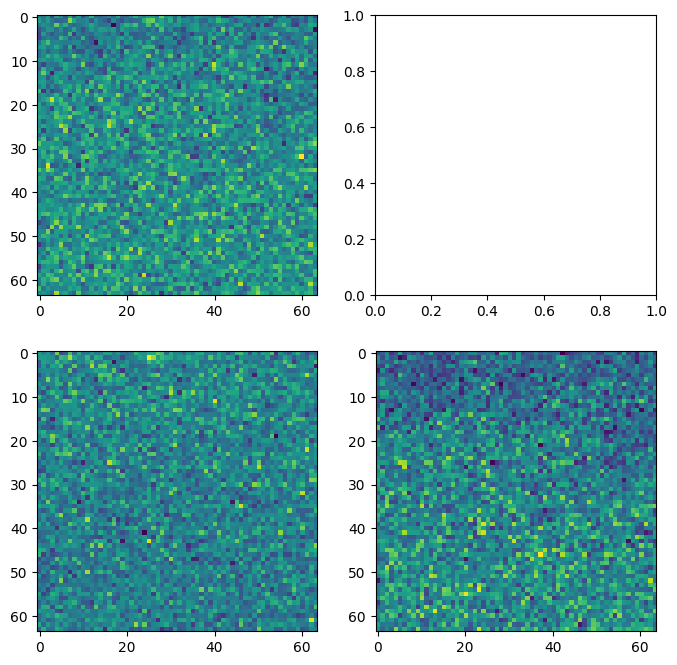

In [17]:
idx = np.random.randint(len(val_dset))
inp_tmp, tar_tmp, *_ = val_dset[idx]
ncols = len(tar_tmp)
nrows = 2
_,ax = plt.subplots(figsize=(4*ncols,4*nrows),ncols=ncols,nrows=nrows)
for i in range(min(ncols,len(inp_tmp))):
    ax[0,i].imshow(inp_tmp[i])

for channel_id in range(ncols):
    ax[1,channel_id].imshow(tar_tmp[channel_id])

In [18]:
if data_t_list is not None:
    val_dset.reduce_data(t_list=data_t_list)

### Finding the optimal mixing ratio.

In [19]:


pred_tiled, rec_loss, logvar_tiled, patch_psnr_tuple, pred_std_tiled, _ = get_dset_predictions(model, val_dset,batch_size,
                                               num_workers=num_workers,
                                               mmse_count=2,
                                                model_type = config.model.model_type,
                                              )
tmp = np.round([x.item() for x in patch_psnr_tuple],2)
print('Patch wise PSNR, as computed during training', tmp,np.mean(tmp))
pred = stitch_predictions(pred_tiled,val_dset )
if 'target_idx_list' in config.data and config.data.target_idx_list is not None and len(config.data.target_idx_list) > pred[0].shape[-1]:
    # it makes it a list. donot make it unless necessary.
    pred = [pred[i][...,:len(config.data.target_idx_list)] for i in range(len(pred))]


Getting predictions: 100%|██████████| 53/53 [00:04<00:00, 11.68it/s]


Patch wise PSNR, as computed during training [22.1  23.22] 22.66


In [20]:
mean_tar = model.data_mean['target'].cpu().numpy()
std_tar = model.data_std['target'].cpu().numpy()
assert mean_tar.shape == (1,2,1,1)
assert mean_tar.shape == std_tar.shape

inp_arr = []
tar_arr = []
for i in tqdm(range(len(val_dset))):
    inp, tar = val_dset[i]
    inp_arr.append(inp[None,:1])
    tar_arr.append((tar - mean_tar)/std_tar)
normalized_inp_patches = np.concatenate(inp_arr,axis=0)
normalized_tar_patches = np.concatenate(tar_arr,axis=0)
del inp_arr, tar_arr
# inp_stitched = stitch_predictions(inp_arr, val_dset)
# inp_stitched = [x[...,0] for x in inp_stitched]
# tar_stitched = stitch_predictions(tar_arr, val_dset)

100%|██████████| 1674/1674 [00:00<00:00, 7545.78it/s]


In [21]:
pred_tiled.shape, normalized_inp_patches.shape, normalized_tar_patches.shape, pred_tiled.std(), normalized_inp_patches.std(), normalized_tar_patches.std()

((1674, 2, 64, 64),
 (1674, 1, 64, 64),
 (1674, 2, 64, 64),
 np.float32(0.5045427),
 np.float32(0.9616718),
 np.float32(0.9804588))

In [22]:
from disentangle.analysis.forward_operator_parameters import get_gaussian_sigma, get_best_mixing
tar =  stitch_predictions(normalized_tar_patches, val_dset)
inp =  stitch_predictions(normalized_inp_patches, val_dset)
inp = [x[...,0] for x in inp]

mixing_t_tar,_ = get_best_mixing(tar, inp, plot=False)
mixing_t_pred,_ = get_best_mixing(pred, inp, plot=False)

# Now we need to find the best mu and sigma
# estimated_inp_patches = normalized_tar_patches[:,0]*mixing_t_tar + normalized_tar_patches[:,1]*(1-mixing_t_tar)
estimated_inp_patches = pred_tiled[:,0]*mixing_t_pred + pred_tiled[:,1]*(1-mixing_t_pred)


100%|██████████| 50/50 [00:00<00:00, 79.45it/s]


Best t value: 0.42


100%|██████████| 50/50 [00:00<00:00, 82.87it/s]

Best t value: 0.42


In [23]:
estimated_inp_patches.shape

(1674, 64, 64)

In [24]:
estimated_inp_patches[idx].mean(), normalized_inp_patches[idx,0].mean(), estimated_inp_patches[idx].std(), normalized_inp_patches[idx,0].std()

(np.float64(0.6201245088459473),
 np.float32(0.76153713),
 np.float64(0.13990374825700228),
 np.float32(0.8817714))

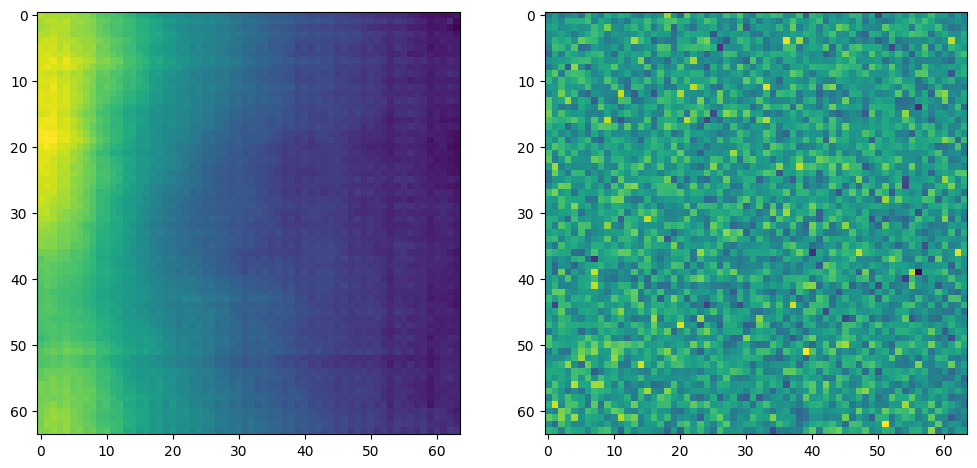

In [25]:
_,ax = plt.subplots(figsize=(12,6),ncols=2)
idx = np.random.randint(0,estimated_inp_patches.shape[0])
ax[0].imshow(estimated_inp_patches[idx])
ax[1].imshow(normalized_inp_patches[idx,0])

In [26]:
def stdev_loss(pred, target, num_patches=10, patch_size=7):
    std_pred = 0 
    std_target = 0
    for i in range(num_patches):
        idx = np.random.randint(0, pred.shape[0])
        h = np.random.randint(0, pred.shape[1]-patch_size)
        w = np.random.randint(0, pred.shape[2]-patch_size)
        std_pred += pred[idx,h:h+patch_size,w:w+patch_size].std()
        std_target += target[idx,h:h+patch_size,w:w+patch_size].std()
    return (std_pred/num_patches - std_target/num_patches)**2

In [27]:
# I have an equation x = alpha * y + beta + sigma * N(0,1)
# in pytorch create three learnable parameters, alpha, beta, sigma
from torch import nn
from tqdm import tqdm
if learn_noise_characteristics:
    from finetunesplit.posterior_sampler import PoissonNoiseHander
    mean_inp, std_inp = val_dset.get_mean_std_for_input()
    mean_inp = torch.Tensor(mean_inp.squeeze()).reshape(-1,)[0]
    std_inp = torch.Tensor(std_inp.squeeze()).reshape(-1,)[0]
    
    
    alpha_dyn = nn.Parameter(torch.tensor(1.0), requires_grad=True)
    beta_dyn = nn.Parameter(torch.tensor(0.0), requires_grad=True)
    sigma_dyn = nn.Parameter(torch.tensor(0.0), requires_grad=True)

    # for poisson noise, we want another scalar and offset.
    alpha_poisson = nn.Parameter(torch.tensor(4.0), requires_grad=True)
    beta_poisson = nn.Parameter(torch.tensor(0.0), requires_grad=True)
    pois_handler = PoissonNoiseHander(mean_inp, std_inp, alpha_poisson, beta_poisson)
    batch_size = 32
    num_steps = 6000
    std_loss_w = 1.0
    poisson_loss_w = 1.0
    optimizer = torch.optim.Adamax([alpha_dyn, beta_dyn, sigma_dyn, alpha_poisson, beta_poisson ], lr=1e-3)
    bar = tqdm(range(num_steps))
    avg_loss = 0.0

    alpha_dyn_arr = []
    beta_dyn_arr = []
    sigma_dyn_arr = []
    loss_arr = []
    std_loss_arr = []
    poisson_loss_arr = []
    poisson_beta_dyn_arr = []
    poisson_alpha_dyn_arr = []

    for step_idx in bar:
        idx = np.random.choice(len(estimated_inp_patches), size=batch_size, replace=False)
        inp_batch = torch.tensor(normalized_inp_patches[idx, 0], dtype=torch.float32, device='cuda')
        est_inp_batch = torch.tensor(estimated_inp_patches[idx], dtype=torch.float32, device='cuda')
        assert inp_batch.shape== est_inp_batch.shape
        pred_inp_batch = alpha_dyn * est_inp_batch + beta_dyn 
        
        # pred_for_poisson = alpha_poisson * pred_inp_batch.detach() + beta_poisson
        # poisson_loss = get_poisson_loss(pred_for_poisson, inp_batch, mu=mean_inp, sigma=std_inp)
        poisson_loss = pois_handler.get_poisson_loss(pred_inp_batch.detach(), inp_batch)
        with_poisson_noise = pois_handler.add_poisson_noise(pred_inp_batch)

        gaussian_noise = sigma_dyn * torch.randn_like(est_inp_batch)
        
        pred_inp_batch_noisy =with_poisson_noise + gaussian_noise
        # print(poisson_loss)
        
        # match the std
        std_loss = stdev_loss(pred_inp_batch_noisy, inp_batch)
        
        recons_loss = ((pred_inp_batch - inp_batch)**2).mean()
        # regularize sigma_dyn to be positive.
        net_loss = recons_loss + 100 * torch.relu(-sigma_dyn) + std_loss_w*std_loss + poisson_loss_w * poisson_loss
        optimizer.zero_grad()
        net_loss.backward()
        optimizer.step()
        avg_loss = 0.9 * avg_loss + 0.1 * recons_loss.item() if avg_loss > 0 else recons_loss.item()
        bar.set_description(f'loss: {avg_loss:.3f}, alpha_dyn: {alpha_dyn.item():.3f}, beta_dyn: {beta_dyn.item():.3f}, sigma_dyn: {sigma_dyn.item():.3f}, std_loss: {std_loss.item():.3f} poisson_loss: {poisson_loss.item():.3f} alpha_poisson: {alpha_poisson.item():.3f} beta_poisson: {beta_poisson.item():.3f}')
        alpha_dyn_arr.append(alpha_dyn.item())
        beta_dyn_arr.append(beta_dyn.item())
        sigma_dyn_arr.append(sigma_dyn.item())
        loss_arr.append(recons_loss.item())
        std_loss_arr.append(std_loss.item()*std_loss_w)
        poisson_loss_arr.append(poisson_loss.item()*poisson_loss_w)
        poisson_alpha_dyn_arr.append(alpha_poisson.item())
        poisson_beta_dyn_arr.append(beta_poisson.item())
    print('Learned parameters: alpha, beta, sigma', alpha_dyn.item(), beta_dyn.item(), sigma_dyn.item(), alpha_poisson.item(), beta_poisson.item())


In [28]:
import pandas as pd 
if learn_noise_characteristics:
    _,ax = plt.subplots(figsize=(20,8),ncols=5,nrows=2)
    pd.Series(alpha_dyn_arr).rolling(100).mean().plot(ax=ax[0,0], title='alpha')
    pd.Series(beta_dyn_arr).rolling(100).mean().plot(ax=ax[0,1], title='beta')
    pd.Series(sigma_dyn_arr).rolling(100).mean().plot(ax=ax[0,2], title='sigma')
    pd.Series(poisson_alpha_dyn_arr).rolling(100).mean().plot(ax=ax[0,3], title='poisson_alpha')
    pd.Series(poisson_beta_dyn_arr).rolling(100).mean().plot(ax=ax[0,4], title='poisson_beta')


    pd.Series(loss_arr).rolling(100).mean().plot(ax=ax[1,0], title='recons loss')
    pd.Series(std_loss_arr).rolling(100).mean().plot(ax=ax[1,1], title='std_loss')
    pd.Series(poisson_loss_arr).rolling(100).mean().plot(ax=ax[1,2], title='poisson_loss')


In [29]:
from disentangle.analysis.plot_utils import clean_ax
if learn_noise_characteristics:
    _,ax = plt.subplots(figsize=(20,15),ncols=4,nrows=3)
    for row_idx in range(3):
        idx = np.random.randint(0,estimated_inp_patches.shape[0])
        print(idx)
        ax[row_idx,0].imshow(normalized_inp_patches[idx,0])
        ax[row_idx,1].imshow(estimated_inp_patches[idx])
        noise_free = estimated_inp_patches[idx]*alpha_dyn.item() + beta_dyn.item()
        gaussian_noise = sigma_dyn.item()*np.random.randn(*estimated_inp_patches[idx].shape)
        with_poisson_noise = pois_handler.add_poisson_noise(torch.Tensor(noise_free)).detach().cpu().numpy()
        ax[row_idx,2].imshow(gaussian_noise + noise_free)
        ax[row_idx, 3].imshow(gaussian_noise + with_poisson_noise)
        
        if row_idx == 0:
            ax[row_idx,0].set_title('Input')
            ax[row_idx,1].set_title('Estimated Input')
            ax[row_idx,2].set_title('+ gaussian noise')
            ax[row_idx,3].set_title('+ gaussian noise + poisson noise')
        
    clean_ax(ax)
    # reduce the spacing between the plots
    plt.subplots_adjust(wspace=0.02, hspace=0.02)

In [30]:
normalized_tar_patches.mean(), normalized_tar_patches.std(), pred_tiled.mean(), pred_tiled.std()

(np.float32(0.027616806),
 np.float32(0.9804588),
 np.float32(0.02658048),
 np.float32(0.5045427))

100%|██████████| 50/50 [00:00<00:00, 78.08it/s]


Best t value: 0.42
{'mixing_t_min': np.float64(0.42), 'mixing_t_max': np.float64(0.42), 'mu': np.float64(-0.19345021748030228), 'sigma': np.float64(10.653581311851266), 'gaussian_noise_std': None, 'poisson_handler': None}


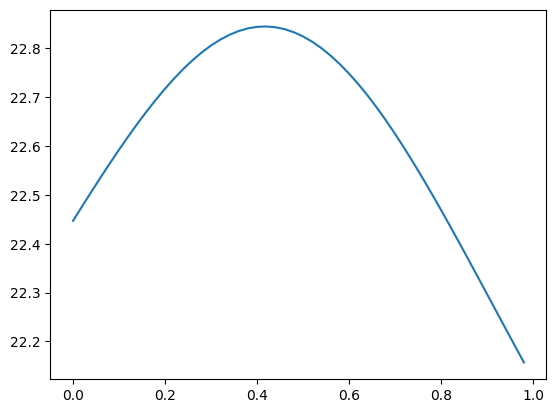

In [31]:
from disentangle.analysis.forward_operator_parameters import get_gaussian_sigma, get_best_mixing
input_gaussian_noise_std = None#get_gaussian_sigma(normalized_inp_patches)
poisson_scaling = None
poisson_offset = None
if learn_noise_characteristics:
    # # I have an equation x = alpha * y + beta + sigma * N(0,1)
    mu = beta_dyn.item()
    sigma = alpha_dyn.item()
    input_gaussian_noise_std = sigma_dyn.item()
    mixing_t = mixing_t_pred
    poisson_scaling = alpha_poisson.item()
    poisson_offset = beta_poisson.item()
    # add_poisson_noise(torch.Tensor(noise_free), alpha_poisson.item(), beta_poisson.item(), mean_inp, std_inp).numpy()
else:
    mixing_t, mu, sigma = get_forward_operator_parameters(val_dset, pred_tiled, normalized_inp_patches, input_gaussian_noise_std= input_gaussian_noise_std,plot=True)
forward_operator_params = {
    'mixing_t_min': max(0.1,mixing_t - delta_t),
    'mixing_t_max': min(0.9,mixing_t + delta_t),
    'mu': mu,
    'sigma': sigma,
    'gaussian_noise_std': input_gaussian_noise_std,
    'poisson_handler': pois_handler if learn_noise_characteristics else None,}
print(forward_operator_params)

In [32]:

# tar_st = stitch_predictions(normalized_tar_patches, val_dset)
# inp_st = stitch_predictions(normalized_inp_patches, val_dset)
# inp_est = [x[...,0]*mixing_t + x[...,1]*(1-mixing_t) for x in tar_st] if isinstance(tar_st, list) else tar_st[...,0]*mixing_t + tar_st[...,1]*(1-mixing_t)
# inp_est = [x*sigma + mu for x in inp_est] if isinstance(inp_est, list) else inp_est*sigma + mu
# # PSNR(inp_st[0][...,0], inp_est[0])

In [33]:
nTar = pred[0].shape[-1]
is_list_prediction = isinstance(pred, list)
tar_unnorm = (val_dset._data if not is_list_prediction else [val_dset.dsets[i]._data for i in range(len(val_dset.dsets))])

if "target_idx_list" in config.data and config.data.target_idx_list is not None:
    nTar =len(config.data.target_idx_list)

if 'input_idx' in config.data and config.data.input_idx is not None:
    inp_unnorm = [x[...,config.data.input_idx] for x in tar_unnorm] if is_list_prediction else tar_unnorm[...,config.data.input_idx]
    tar_unnorm = [x[...,:nTar] for x in tar_unnorm] if is_list_prediction else tar_unnorm[...,:nTar]
else:
    inp_unnorm = [x.mean(axis=-1) for x in tar_unnorm]


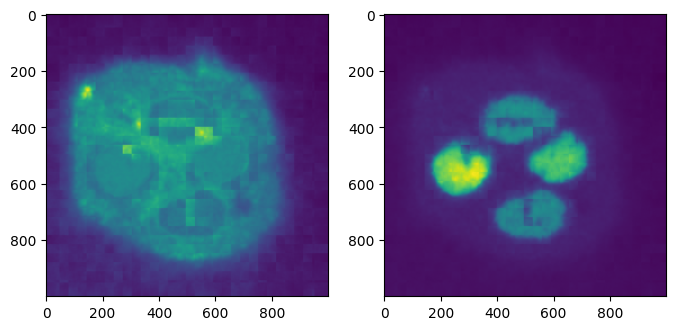

In [34]:
_,ax = plt.subplots(figsize=(8,4),ncols=2)
if is_list_prediction:
    ax[0].imshow(pred[0][0,...,0])
    ax[1].imshow(pred[0][0,...,1])
else:
    ax[0].imshow(pred[0,...,0])
    ax[1].imshow(pred[0,...,1])

### A model to yield augmented predictions.

In [35]:
import torch.nn as nn 
class NnModel(nn.Module):
    def __init__(self, model):
        super(NnModel, self).__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x)[0]

singleoutput_model = NnModel(model).cuda()

In [36]:
# with_inp_transforms = True
# mmse_count = 5

In [37]:
pred_transform_obj = get_transform_obj(ch1_transforms, ch2_transforms, correlation_preserving_transforms=corr_pres_trans)
print('')
print('')
inp_transform_obj = get_input_transform_obj(inp_transforms) if with_inp_transforms else None


Transforms for Ch1: [('identity', {})]
Transforms for Ch2: [('identity', {})]
Using correlation preserving transforms
Using transform types: {0: [Identity(transform_type='identity')], 1: [Identity(transform_type='identity')]}


Transforms for Ch1: [('rotate', {}), ('hflip', {}), ('vflip', {})]
Transforms for Ch2: [('rotate', {}), ('hflip', {}), ('vflip', {})]
Using correlation preserving transforms
Using transform types: {0: [Rotate(transform_type='rotate'), HFlip(transform_type='hflip'), VFlip(transform_type='vflip')], 1: [Rotate(transform_type='rotate'), HFlip(transform_type='hflip'), VFlip(transform_type='vflip')]}


In [38]:
aug_model = PosteriorSampler(singleoutput_model, pred_transform_obj, forward_operator_params=forward_operator_params, mmse_count=mmse_count,
                                        k_forward_pass=k_forward_pass, input_transforms=inp_transform_obj, keep_original_input_fraction=keep_original_input_fraction)

[PosteriorSampler] k_forward_pass: 2
[PosteriorSampler] mixing_t range: [0.42, 0.42], mu: -0.19345021748030228, sigma: 10.653581311851266, gaussian_noise_std: None
[PosteriorSampler] Input transforms enabled
[PosteriorSampler] keep_original_input_fraction: 0.5


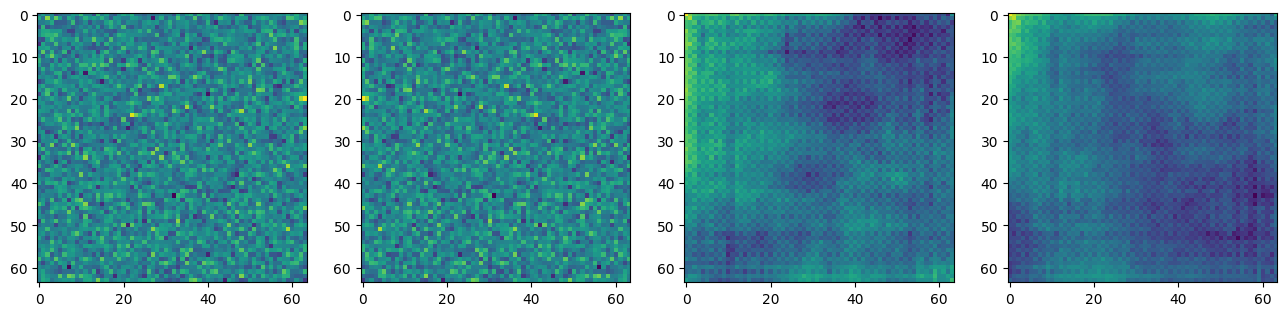

In [39]:
if inp_transform_obj is not None:
    dloader = DataLoader(val_dset, batch_size=5, shuffle=False, num_workers=0)
    for batch in dloader:
        inp_b, tar_b = batch
        break
    
    with torch.no_grad():   
        pred, applied_transforms, inp_transformed = aug_model.one_forward_pass_inp(inp_b.cuda())

    _,ax = plt.subplots(figsize=(16,4),ncols=4)
    ax[0].imshow(inp_b[0,0])
    ax[1].imshow(inp_transformed[0,0].cpu())
    ax[2].imshow(pred[0,0].cpu())
    ax[3].imshow(pred[1,0].cpu())

In [40]:

# with torch.no_grad():
#     output, pred1_mmse = aug_model(inp_b.cuda())
#     output = [x.cpu().numpy() for x in output]
#     pred1_mmse = pred1_mmse.cpu().numpy()

# _,ax = plt.subplots(figsize=(6,6),ncols=2,nrows=2)
# # img_idx = np.random.randint(low=0, high=len(inp_b))
# ax[0,0].set_title('Pred')
# ax[0,1].set_title('Target')
# ax[0,0].imshow(output[0][img_idx,0])
# ax[0,1].imshow(tar_b[img_idx,0])
# ax[1,0].imshow(output[0][img_idx,1])
# ax[1,1].imshow(tar_b[img_idx,1])

In [41]:
if custom_image_size is None:
    skip_pixels = config.data.image_size - image_size_for_grid_centers
else:
    skip_pixels = custom_image_size - image_size_for_grid_centers

In [42]:
# # Looking at the sanity of LC setup.


# _,ax = plt.subplots(figsize=(15,3),ncols=5)
# idx = np.random.randint(len(val_dset    ))
# print(idx)
# inp, tar = val_dset[idx]
# ax[0].imshow(inp[0])
# ax[1].imshow(inp[1])
# ax[2].imshow(inp[2])
# ax[3].imshow(tar[0])
# ax[4].imshow(tar[1])

# with torch.no_grad():
#     inp_c = torch.Tensor(inp[None]).cuda()
#     pred, _  = model(inp_c)

# with torch.no_grad():
#     pred2, inp_c2 = aug_model.one_forward_pass(pred, inp_c[:,1:])

# _,ax = plt.subplots(figsize=(15,3),ncols=5)
# # idx = np.random.randint(len(val_dset    ))
# ax[0].imshow(inp_c2[0,0].cpu().numpy())
# ax[1].imshow(inp_c2[0,1].cpu().numpy())
# ax[2].imshow(inp_c2[0,2].cpu().numpy())
# ax[3].imshow(pred2[0,0].cpu().numpy())
# ax[4].imshow(pred2[0,1].cpu().numpy())

# with torch.no_grad():
#     pred3, inp_c3 = aug_model.one_forward_pass(pred2, inp_c[:,1:])

# _,ax = plt.subplots(figsize=(15,3),ncols=5)
# # idx = np.random.randint(len(val_dset    ))
# ax[0].imshow(inp_c3[0,0].cpu().numpy())
# ax[1].imshow(inp_c3[0,1].cpu().numpy())
# ax[2].imshow(inp_c3[0,2].cpu().numpy())
# ax[3].imshow(pred3[0,0].cpu().numpy())
# ax[4].imshow(pred3[0,1].cpu().numpy())

In [43]:
# mmse_count = 5
# num_workers=0

In [44]:

pred_b_list = []
var_list = []
err_list  = []
one_step_pred_mmse_list = []
dloader = DataLoader(val_dset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
for batch in tqdm(dloader):
    with torch.no_grad():
        inp_b, tar_b = batch
        tar_b_normalized = model.normalize_target(tar_b.cuda()).cpu().numpy()
        pred_b, one_step_pred_mmse = aug_model(inp_b.cuda())
        
        pred_b = [x.cpu().numpy()[:,None] for x in pred_b]
        pred_b = np.concatenate(pred_b, axis=1)
        one_step_pred_mmse = one_step_pred_mmse.cpu().numpy()
        
        
        ec_pred_b = pred_b
        ec_tar_b_normalized = tar_b_normalized
        ec_one_step_pred_mmse = one_step_pred_mmse
        if skip_pixels > 1:
            ec_pred_b = pred_b[...,skip_pixels//2:-skip_pixels//2,skip_pixels//2:-skip_pixels//2]
            ec_tar_b_normalized = tar_b_normalized[...,skip_pixels//2:-skip_pixels//2,skip_pixels//2:-skip_pixels//2]
            ec_one_step_pred_mmse = one_step_pred_mmse[...,skip_pixels//2:-skip_pixels//2,skip_pixels//2:-skip_pixels//2]
        
        var_b, err_b = compute_for_one_batch(ec_pred_b, ec_tar_b_normalized, elem_size=elem_size,mmse_sample_for_error=ec_one_step_pred_mmse if compute_error_from_first_prediction else None,)
        one_step_pred_mmse_list.append(one_step_pred_mmse)
        # compute for one batch, both calibration and coverage. 
        pred_b_list.append(pred_b[:,0])
        var_list.append(var_b)
        err_list.append(err_b)

pred_b = np.concatenate(pred_b_list, axis=0)
var = np.concatenate(var_list, axis=0)
err = np.concatenate(err_list, axis=0)
one_step_pred_mmse = np.concatenate(one_step_pred_mmse_list, axis=0)

  0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 53/53 [00:51<00:00,  1.04it/s]


In [45]:
pred_stitched  = stitch_predictions(pred_b, val_dset)
pred_one_step_stitched = stitch_predictions(one_step_pred_mmse, val_dset)

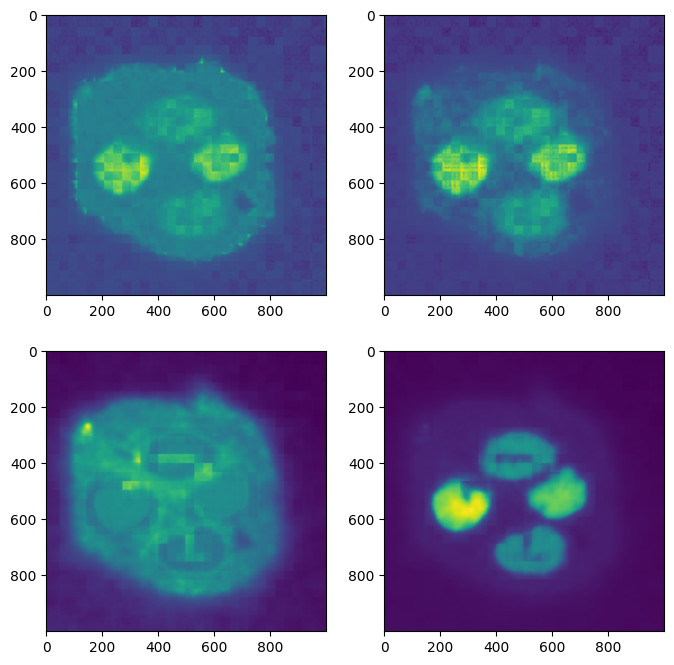

In [46]:
_,ax = plt.subplots(figsize=(8,8),ncols=2,nrows=2)
if is_list_prediction:
    ax[0,0].imshow(pred_stitched[0][0,...,0])
    ax[0,1].imshow(pred_stitched[0][0,...,1])
    ax[1,0].imshow(pred_one_step_stitched[0][0,...,0])
    ax[1,1].imshow(pred_one_step_stitched[0][0,...,1])
else:
    ax[0,0].imshow(pred_stitched[0,...,0])
    ax[0,1].imshow(pred_stitched[0,...,1])
    ax[1,0].imshow(pred_one_step_stitched[0,...,0])
    ax[1,1].imshow(pred_one_step_stitched[0,...,1])

In [47]:
tar_unnorm[0].shape

(1, 1000, 1000, 2)

In [48]:
is_list_prediction

True

In [49]:
if is_list_prediction:
    print(RangeInvariantPsnr(tar_unnorm[0][0,...,0]*1.0, pred_stitched[0][0,...,0]).item())
else:
    print(RangeInvariantPsnr(tar_unnorm[0,...,0]*1.0, pred_stitched[0,...,0]).item())

20.764690399169922


In [50]:
ch_idx = 0
print(np.quantile(var[:,ch_idx, :4], [0.0, 0.01,0.05, 0.95,0.99,1.0]).round(3))
print(np.quantile(err[:,ch_idx], [0.0, 0.01,0.05, 0.95,0.99,1.0]).round(3))

[0.000e+00 0.000e+00 1.000e-03 1.020e-01 3.180e-01 2.385e+00]
[0.33  0.43  0.493 1.321 1.616 3.037]


In [51]:
factors = []
offsets = []
achieved_percentiles = []
for ch_idx in range(var.shape[1]):
    print('Starting the grid search')
    factor_ch, offset_ch, achieved_percentile_ch = grid_search(err[:,ch_idx], var[:,ch_idx], init_delta=10, init_factor=10,around_center=False)
    factors.append(factor_ch)
    offsets.append(offset_ch)
    achieved_percentiles.append(achieved_percentile_ch)
    
    print('')
    # break


Starting the grid search
2.97 10 D0
8.08 20 D0
14.87 30 D0
24.28 40 D0
Upscaling 10 -> 20
33.55 50 D0
47.38 70 D0
56.07 90 D1
47.38 70 D2
52.23 80.0 D3
50.06 75.0 D3
48.75 72.5 D4
50.06 75.0 D5
49.41 73.75 D6
49.73 74.375 D6
49.89 74.6875 D6
50.06 75.0 D7

Starting the grid search
56.86 10 D0
34.18 5.0 D1
56.86 10.0 D2
48.08 7.5 D3
52.85 8.75 D4
50.52 8.125 D4
49.32 7.8125 D5
50.52 8.125 D6
49.92 7.96875 D7



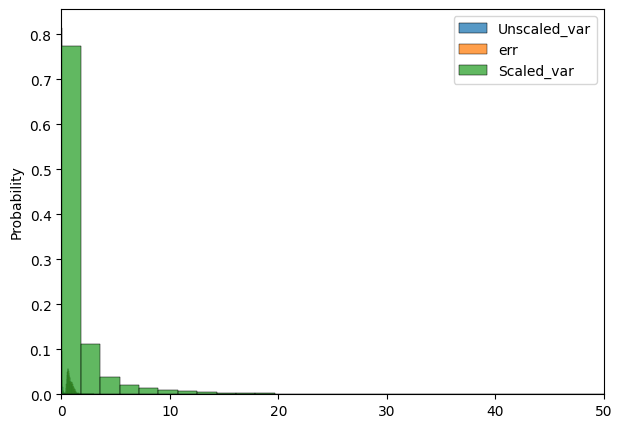

In [52]:

_,ax = plt.subplots(figsize=(7,5))
log_scale = False
ch_idx = 0
sns.histplot(var[:,ch_idx,:].reshape(-1,), bins=100,log_scale=log_scale, ax=ax, label='Unscaled_var', stat='probability')
sns.histplot(err[:,ch_idx], bins=100,log_scale=log_scale, ax=ax, label='err', stat='probability')
sns.histplot(factors[ch_idx]*var[:,ch_idx,:4].reshape(-1,) + offsets[ch_idx], bins=100,log_scale=log_scale, ax=ax, label='Scaled_var', stat='probability')
plt.xlim(0, 50)
plt.legend()

In [53]:
var.shape

(16740, 2, 20)

In [54]:
q_bkg = 0.01
q_err = []
q_var = []
masks = []
for ch_idx in range(var.shape[1]):
    err_data = err[:,ch_idx].reshape(-1,).copy()
    # average MAE of background should match the actual error. Shift
    var_data = np.mean(var[:,ch_idx,:], axis=-1).reshape(-1,).copy()
    assert err_data.shape == var_data.shape

    q_err.append(np.quantile(err_data, q_bkg))
    q_var.append(np.quantile(var_data, q_bkg))
    offset = q_err[ch_idx] - q_var[ch_idx]
    print('Offset based on background quantile', offset)
    mask_err = err_data >= q_err[ch_idx]
    mask_var = var_data >= q_var[ch_idx]
    mask = np.logical_and(mask_err, mask_var)
    masks.append(mask)

Offset based on background quantile 0.42777318
Offset based on background quantile 0.35320014


In [55]:
factors_shifted = []
offsets_shifted = []
achieved_percentiles = []
for ch_idx in range(var.shape[1]):
    mask = masks[ch_idx]
    err_grid_data = err[mask,ch_idx] - q_err[ch_idx] # to make it non-negative. one could ideally use q_err otherwise
    var_grid_data = var[mask,ch_idx] - q_var[ch_idx] # to make it non-negative. one could ideally use q_var otherwise
    var_grid_data = np.clip(var_grid_data, a_min=0, a_max=None)
    assert err_grid_data.min() >= 0
    assert var_grid_data.min() >= 0, f'var min: {var_grid_data.min()}'
    print('Starting the grid search')
    factor_ch, offset_ch, achieved_percentile_ch = grid_search(err_grid_data, var_grid_data, init_delta=10, init_factor=10,around_center=False)
    factors_shifted.append(factor_ch)
    offsets_shifted.append(offset_ch)
    achieved_percentiles.append(achieved_percentile_ch)
    
    print('')


Starting the grid search
15.95 10 D0
33.53 20 D0
45.26 30 D0
52.87 40 D1
45.26 30 D2
49.39 35.0 D2
51.27 37.5 D3
49.39 35.0 D4
50.33 36.25 D5
49.88 35.625 D6
50.10 35.9375 D7

Starting the grid search
78.64 10 D0
67.69 5.0 D0
50.17 2.5 D0
27.93 1.25 D1
50.17 2.5 D2
41.51 1.875 D3
46.17 2.1875 D3
48.26 2.34375 D3
50.17 2.5 D4
48.26 2.34375 D5
49.30 2.421875 D5
49.66 2.4609375 D5
50.17 2.5 D6
49.66 2.4609375 D7



In [56]:
factors_shifted, offsets_shifted

([35.9375, 2.4609375], [0.0, 0.0])

In [57]:
factors, offsets

([75.0, 7.96875], [0.0, 0.0])

In [58]:
np.array(q_var)[None,:,None].shape

(1, 2, 1)

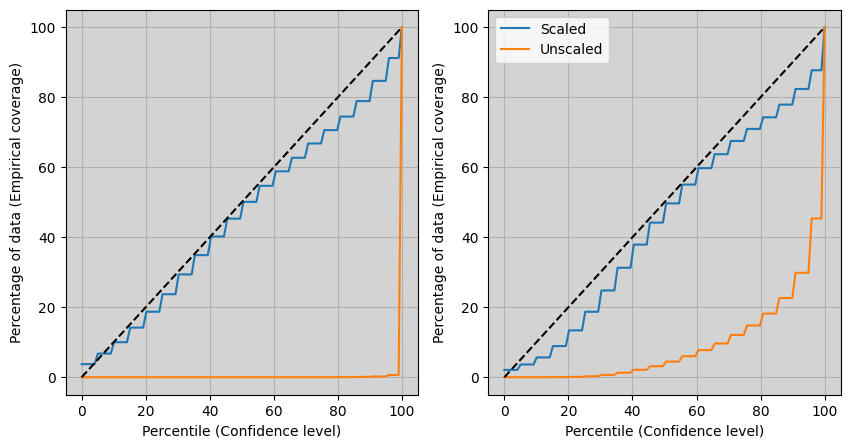

In [59]:
# data_left_oriented = plot_coverage_plot(var, err, factors, offsets, around_center=False)
# works.
# data_left_oriented = plot_coverage_plot( np.tile(var_grid_data[:,None],(1,2,1)), 
#                                          np.tile(err_grid_data[:,None], (1,2)), 
#                                          factors_shifted, offsets_shifted, around_center=False)

# works.
# data_left_oriented = plot_coverage_plot( var[mask] -np.array(q_var)[None,:,None], 
#                                          err[mask], factors_shifted, [k+q_err[i] for i,k in enumerate(offsets_shifted)], around_center=False)

# works
data_left_oriented = plot_coverage_plot( var -np.array(q_var)[None,:,None], 
                                         err, factors_shifted, [k+q_err[i] for i,k in enumerate(offsets_shifted)], around_center=False)

In [60]:
# sns.displot(factors[ch_idx]*var[:,ch_idx,:4].reshape(-1,) + offsets[ch_idx], log_scale=False, kind='kde')
# sns.displot(var[:,ch_idx,0], log_scale=False, kind='kde')

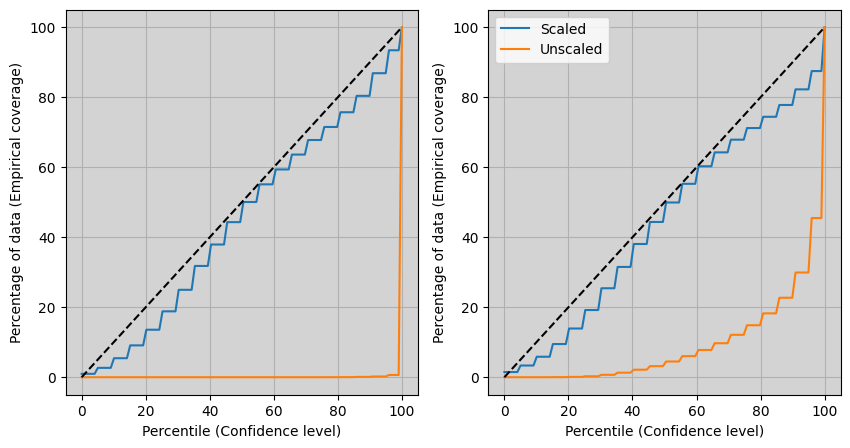

In [61]:
_ = plot_coverage_plot( var, err, factors, offsets, around_center=False)

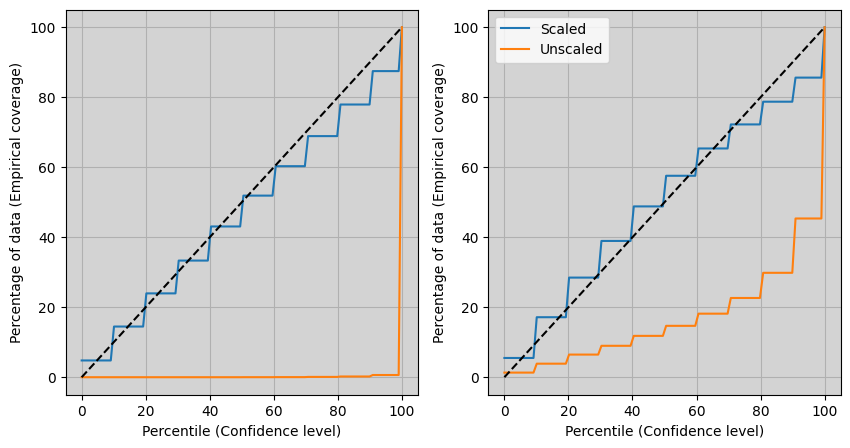

In [62]:
# data_centered = plot_coverage_plot(var, err, factors, offsets, around_center=True)
data_centered = plot_coverage_plot( var -np.array(q_var)[None,:,None], 
                                         err, factors_shifted, [k+q_err[i] for i,k in enumerate(offsets_shifted)], around_center=True)

In [63]:
perfect = np.linspace(0,100,100)
for col_idx in range(var.shape[1]):
    act = data_centered[col_idx]['scaled'][1]
    mean_err = np.abs(perfect - act).mean() 
    max_err = np.abs(perfect - act).max()
    print(f'Centered: Channel {col_idx} MAE {mean_err:.2f}, MAX Err {max_err:.2f}')

Centered: Channel 0 MAE 4.21, MAX Err 11.98
Centered: Channel 1 MAE 4.19, MAX Err 13.39


In [64]:
perfect = np.linspace(0,100,100)
for col_idx in range(var.shape[1]):
    act = data_left_oriented[col_idx]['scaled'][1]
    mean_err = np.abs(perfect - act).mean() 
    max_err = np.abs(perfect - act).max()
    print(f'LeftOriented: Channel {col_idx} MAE {mean_err:.2f}, MAX Err {max_err:.2f}')

LeftOriented: Channel 0 MAE 4.15, MAX Err 11.00
LeftOriented: Channel 1 MAE 5.98, MAX Err 12.60


In [65]:
# LeftOriented: Channel 0 MAE 8.36, MAX Err 18.82
# LeftOriented: Channel 1 MAE 3.11, MAX Err 7.67


In [66]:
outs = []
inp, _ = val_dset[0]
inp = torch.Tensor(inp[None]).cuda()
for _ in range(5):
    out,_ = model(inp)
    outs.append(out.detach().cpu().numpy())

In [67]:
np.abs(outs[0] - outs[1]).max()

np.float32(0.056429863)